In [68]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

Bernoulli = tf.contrib.distributions.Bernoulli
st = tf.contrib.bayesflow.stochastic_tensor

data = input_data.read_data_sets("MNIST_data/", one_hot=True).test
data.images[data.images>0.5] = 1.0
data.images[data.images<=0.5] = 0.0

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Utility functions

In [114]:
def plot_banded_error(errs, label, ax=None):
    ax = ax or plt
    m = np.mean(errs, axis=0)
    s = np.std(errs, axis=0)
    line, = ax.plot(np.arange(1, len(m)+1), m, '.-', label=label)
  #  ax.fill_between(np.arange(1, len(m)+1), m-s, m+s, color=line.get_color(), alpha=0.075)

def fatlegend(ax, *a, **kw):
    leg = ax.legend(*a, **kw)
    for l in leg.legendHandles:
        l.set_linewidth(l.get_linewidth()*2.0)
    return leg

def add_layer(inputs, wn, bn, in_dim, out_dim, af=None):
    try:
        w = tf.get_variable(wn, [in_dim, out_dim], initializer=tf.truncated_normal_initializer)
        b = tf.get_variable(bn, [1, out_dim], initializer=tf.truncated_normal_initializer)
    except:
        with tf.variable_scope(tf.get_variable_scope(), reuse=True):
            w = tf.get_variable(wn, [in_dim, out_dim])
            b = tf.get_variable(bn, [1, out_dim])
    if af is None:
        return tf.matmul(inputs, w) + b
    return af(tf.matmul(inputs, w) + b)

def get_weights(wn, bn, in_dim, out_dim):
    with tf.variable_scope(tf.get_variable_scope(), reuse=True):
        w = tf.get_variable(wn, [in_dim, out_dim])
        b = tf.get_variable(bn, [1, out_dim])
    return [w,b]

def prob(p, s):
    return s*p + (1.0-s)*(1.0-p)

def comp_gd(p, f, g, mg, w, linear, dmg=tf.zeros([2,1])):
    if not linear:
        est = [list(dd) for dd in opt.compute_gradients(tf.reduce_mean(f/g*mg, 0), w)]   
        return est
    
    est = [list(dd) for dd in opt.compute_gradients(tf.reduce_mean((f-g)*p, 0), w)]
    if mg is not None:
        dmg = opt.compute_gradients(tf.reduce_mean(mg, 0), w)
        for i in range(2):
            est[i][0] += dmg[i][0]
    return est

### Parameters

In [115]:
batch_size = 40
ns = 1
eps = 1e-6
lr=1e-3
alpha = 0.9
PD = False
steps = 50000

### Sigmoid belief networks

In [116]:
x = tf.placeholder(tf.float32, [None, 392])
h = tf.tile(add_layer(x, "wxh", "bxh", 392, 200, tf.nn.sigmoid), [ns, 1])
if not PD:
    sh = tf.stop_gradient(Bernoulli(probs=h, dtype=tf.float32).sample())
else:
    sh = tf.stop_gradient(Bernoulli(probs=h, dtype=tf.float32).sample()-h)+h
h2 = tf.tile(add_layer(sh, "whh", "bhh", 200, 200, tf.nn.sigmoid), [ns, 1])
if not PD:
    sh2 = tf.stop_gradient(Bernoulli(probs=h2, dtype=tf.float32).sample())
else:
    sh2 = tf.stop_gradient(Bernoulli(probs=h2, dtype=tf.float32).sample()-h2)+h2
y = add_layer(sh2, "why", "bhy", 200, 392, tf.nn.sigmoid)
y_expect = tf.reduce_mean(tf.reshape(y, [ns**2, batch_size, 392]), 0)
y_ = tf.placeholder(tf.float32, [None, 392])

nll = tf.reduce_mean(tf.reduce_sum(-tf.log(tf.clip_by_value(prob(y_expect, y_), eps, 1.0-eps)), 1))
loss = tf.reduce_sum(-tf.log(tf.clip_by_value(prob(y, tf.tile(y_,[ns**2,1])), eps, 1.0-eps)), 1, keep_dims=True)

### Gradient estimators

In [124]:
bsln = tf.placeholder(tf.float32)
bslnv = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(lr)

p2 = tf.log(tf.clip_by_value(prob(h2, sh2), eps, 1.0-eps))
p = tf.log(tf.clip_by_value(prob(h, sh), eps, 1.0-eps))

def gd_est(md, linear=True):
    func = {
        0: lambda: [loss]+[None]*5+[tf.constant(0.)]*2,
        1: muProp,
        2: DARN,
        3: baseline,
        4: NVIL
    }
    f, g, mg, g2, mg2, tr, m, v = func.get(md)()
    est = [list(dd) for dd in opt.compute_gradients(nll, get_weights("why", "bhy", 200, 392), linear)]
    dfdh2 = comp_gd(p2, tf.stop_gradient(f),
                    g2, mg2, get_weights("whh", "bhh", 200, 200), linear)
    dfdh = comp_gd(p, tf.stop_gradient(tf.reduce_mean(tf.reshape(f,[ns, ns*batch_size, 1]), 0)),
                   g, mg, get_weights("wxh", "bxh", 392, 200), linear)
    est += dfdh2 + dfdh
    if tr is not None:
        est += list(tr)
 
    for i in range(6):
        est[i][0] = tf.check_numerics(est[i][0], "wrong_"+str(i))
    
    train_step = opt.apply_gradients(est)
    return train_step, y_expect, nll, m, v

def muProp():
    hh = add_layer(h, "whh", "bhh", 200, 200, tf.nn.sigmoid)
    ch = add_layer(hh, "why", "bhy", 200, 392, tf.nn.sigmoid)
    loss_ch = tf.reduce_sum(-tf.log(tf.clip_by_value(prob(ch, tf.tile(y_,[ns,1])), eps, 1.0-eps)), 1, keep_dims=True)
    dh = tf.gradients(loss_ch, h)[0]
    g = tf.stop_gradient(loss_ch+tf.reduce_sum(dh*(sh-h),1,keep_dims=True))
    mg = tf.stop_gradient(dh) * h

    ch2 = add_layer(h2, "why", "bhy", 200, 392, tf.nn.sigmoid)
    loss_ch2 = tf.reduce_sum(-tf.log(tf.clip_by_value(prob(ch2, tf.tile(y_,[ns**2,1])), eps, 1.0-eps)), 1, keep_dims=True)
    dh2 = tf.gradients(loss_ch2, h2)[0]
    g2 = tf.stop_gradient(loss_ch2+tf.reduce_sum(dh2*(sh2-h2),1,keep_dims=True))
    mg2 = tf.stop_gradient(dh2) * h2
    
    return loss, g, mg, g2, mg2, None, tf.constant(0.), tf.constant(0.)
        
def DARN():
    hh = add_layer(sh, "whh", "bhh", 200, 200, tf.nn.sigmoid)
    ch = add_layer(hh, "why", "bhy", 200, 392, tf.nn.sigmoid)
    loss_ch = tf.reduce_sum(-tf.log(tf.clip_by_value(prob(ch, tf.tile(y_,[ns,1])), eps, 1.0-eps)), 1, keep_dims=True)
    dh = tf.gradients(loss_ch, sh)[0]
    g = tf.stop_gradient(tf.reduce_mean(tf.reshape(loss,[ns, ns*batch_size, 1]), 0) + dh*(0.5-sh)) * p    
    
    dh2 = tf.gradients(loss, sh2)[0]
    g2 = tf.stop_gradient(loss + dh2*(0.5-sh2)) * p2

    return loss, g, None, g2, None, None, tf.constant(0.), tf.constant(0.)

def baseline():
    b = alpha*bsln + (1.0-alpha)*tf.reduce_mean(loss)
    g = tf.stop_gradient(b) * p
    f = tf.stop_gradient(loss) * p
    return f, g, None, None, b, tf.constant(0.)

def NVIL():
    ch = add_layer(x, "wh", "bh", 392, 100, tf.tanh)
    cy = add_layer(ch, "wy", "by", 100, 1)
    b = alpha*bsln + tf.reduce_mean((1.0-alpha)*(loss-cy))
    vv = tf.reduce_mean(tf.square(loss-cy-tf.reduce_mean(loss-cy)))/tf.maximum(1.0, (ns-1))
    v = alpha*bslnv + (1.0-alpha)*vv
    g = tf.stop_gradient((cy+b)/tf.maximum(1.0,tf.sqrt(v))) * p
    f = tf.stop_gradient(loss/tf.maximum(1.0,tf.sqrt(v))) * p
    tr = opt.compute_gradients(tf.reduce_mean(tf.square(tf.stop_gradient(loss-b)-cy)), [get_weights("wh", "bh", 392, 100),
                                                                                        get_weights("wy", "by", 100, 1)])
    return f, g, None, tr, b, v

def ST_():
    train_step = tf.train.AdamOptimizer(lr).minimize(nll)
    return train_step, y_expect, nll, tf.constant(0.), tf.constant(0.)

In [125]:
saver = tf.train.Saver()
def train(train_op):

    with tf.Session() as sess:
        tf.set_random_seed(1234)
        bl = 0.
        vr = 0.
        ll = np.empty((1000, steps/1000))
        sess.run(tf.global_variables_initializer())

        for i in range(steps):
            batch_ = data.next_batch(batch_size)[0]
            batch_xs = batch_[:,0:392]
            batch_ys = batch_[:,392:784]

            res = sess.run(train_op, {x: batch_xs, y_: batch_ys, bsln: bl, bslnv: vr})
            bl = res[-2]
            vr = res[-1]
            
            ll[i%1000, i/1000] = res[-3]
            if (i+1)%1000==0:
                print (i+1)/1000, np.mean(ll[:, i/1000], 0),
#        save_path = saver.save(sess, "model/model.ckpt")
    return ll, batch_xs, batch_ys, res[1]

In [ ]:
#train_op = ST_()
train_op = gd_est(1, True)
result = train(train_op)
mpl = result[0]

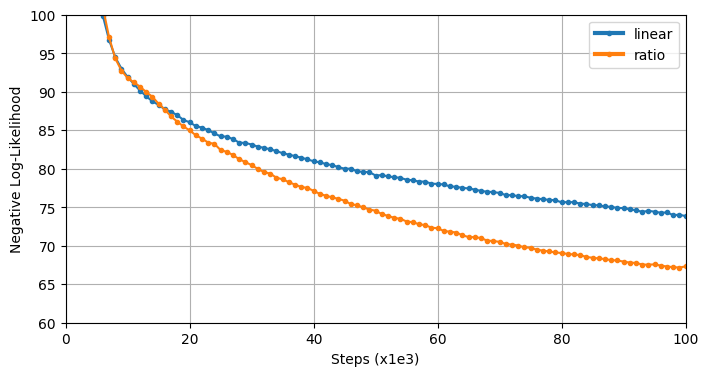

In [678]:
plt.style.use('default')
fig, ax = plt.subplots(1,1, figsize=(8,4))
plt.xlim(0, 100)
plt.ylim(60, 100)

plot_banded_error(mpl,"linear",ax)
plot_banded_error(mpr,"ratio",ax)

fatlegend(ax)
plt.ylabel("Negative Log-Likelihood")
plt.xlabel("Steps (x1e3)")
ax.grid(True)
plt.show()
fig.savefig('foo.png')

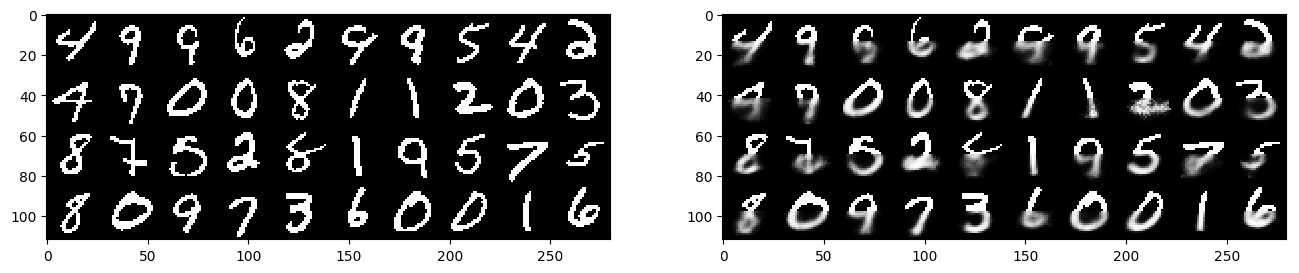

In [248]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
up = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[1]]], 1)
dw = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[2]]], 1)
c_fig = np.concatenate(np.split(np.concatenate([up,dw], 0), batch_size/10, 1), 0)
dwy = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[3]]], 1)
p_fig = np.concatenate(np.split(np.concatenate([up,dwy], 0), batch_size/10, 1), 0)
ax[0].imshow(c_fig, cmap=plt.cm.gray, interpolation='none')
ax[1].imshow(p_fig, cmap=plt.cm.gray, interpolation='none')
ax[0].grid(False)
ax[1].grid(False)
plt.show()